# The difference is defined by initial state of ESN

# initialization of ESN

二つのESNの内部状態の初期値を変えて、その差を見る関数を作る.

初期値はseedで管理

## ESN, output, input class
input, output, middle layer

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt
import copy

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        #self.w_in = np.zeros((dim_x, dim_u))
        #self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)

    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, input_scale=1.0, eps=0.20, r=4.0, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=0)
        self.input_scale=input_scale # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-self.input_scale, self.input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r

        np.random.seed(seed=rseed)
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        #print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        np.random.seed(seed=self.rseed)
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        np.random.seed(seed=self.rseed)
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
            print("error")
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
        #print("self.x[0] = ", buf_x[0], "  (np.dot(self.w_net, self.x) + x_in)[0] = ", (np.dot(self.w_net, self.x) + x_in)[0])
        #print("np.tanh( (np.dot(self.w_net, self.x) + x_in)[0]) =", np.tanh((np.dot(self.w_net, self.x) + x_in)[0]) )

    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## Discrete ESN for checking state values

In [2]:
class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale_spon, activation_func, 
                 rseed=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, dim_out=0, x_init=None, **kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, rseed=rseed,
                                                 x_init=x_init, **kwargs)#assign dim_rv to dim_x
        #create instance
        ex_w_scale=1.0
        self.Input_external = Input_external(dim_u_ex, dim_rv, ex_w_scale, rseed=rseed)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, input_scale=input_scale_spon, eps=spon_eps, r=spon_r, rseed=seed_spon)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update( (x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [3]:
def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=0.5, input_scale_spon=0.4, rseed=0, activation_func=np.tanh, 
                    washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, x_init=None, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(seed_spon=seed_spon, dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale_spon=input_scale_spon, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, rho=rho, rseed=rseed, x_init=x_init)
    
    washout_len=washout_len
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        ax1[0].plot(time, x_in_spon)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return x_in_spon, states_series


## observation example

Debug
dim_u =  1
x_in_spon.shape =  (20000, 0)
states_series.shape =  (20000, 50)
[[ 0.95499235 -0.97254777 -0.6603332  ... -0.52219546 -0.43012244
   0.72768503]
 [ 0.90145075  0.49591577 -0.83232635 ... -0.9987541  -0.53952634
  -0.92564476]
 [-0.66964936 -0.08343433  0.96137273 ...  0.8505595   0.5862407
  -0.9290235 ]
 ...
 [ 0.9924397   0.3124535  -0.86972046 ... -0.06936706  0.897479
  -0.98116857]
 [ 0.3190426  -0.7200893  -0.19312394 ...  0.9817057   0.41031674
  -0.8168186 ]
 [ 0.33347917 -0.777789    0.7949598  ...  0.51625717  0.55077654
   0.7726343 ]]


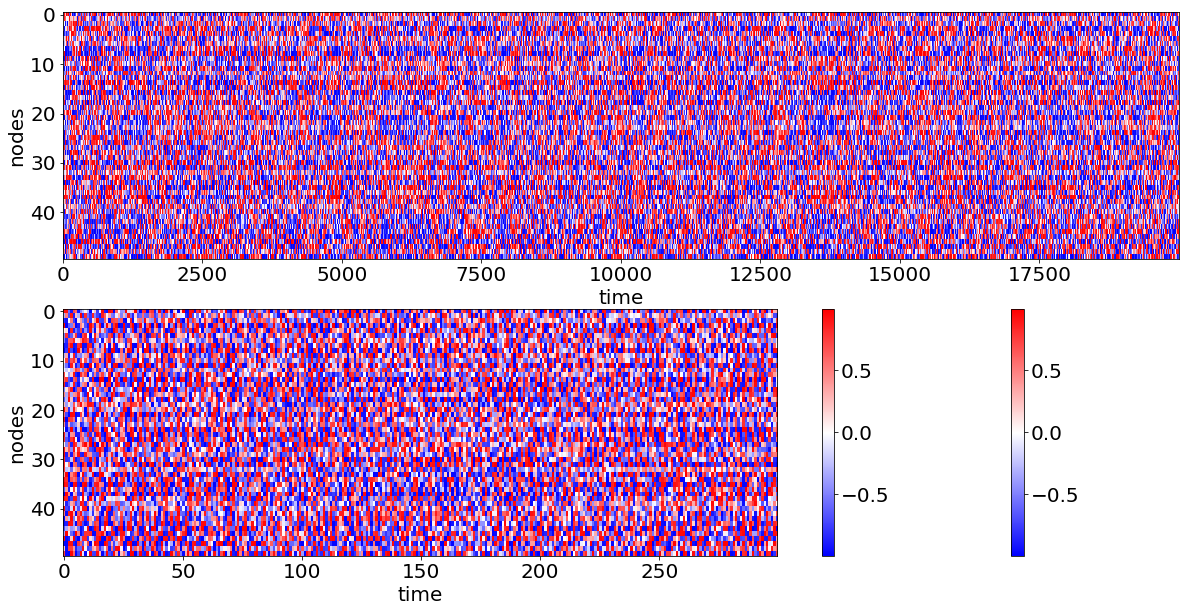

In [4]:
np.random.seed(1010)
dim_u_spon=0
dim_rv=50
dim_u=1
Time_leng=2*10**4

#print(x_init)

input_scale_spon=0
density=1.0

rho=2.0
#change external input_scale 0.01~1.0
ex_input_scale=0.01
u_ex=ex_input_scale*np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))

np.random.seed(100)
x_init=np.random.uniform(-1.0, 1.0, dim_rv)

rseed=1
x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, input_scale_spon=input_scale_spon, 
                                         rseed=rseed, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                         spon_eps=0.20, spon_r=4.0, x_init=x_init, plot=True, verbose=True)

print(states_series[-1000:, :])

In [ ]:
print(max(x_in_spon))

[]


<ipython-input-11-9831501a270e>:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  print(max(x_in_spon))


# ESPindex 1external

## ESN 1 random input, rhos & input_scale

In [ ]:
import time
#from multiprocessing import Lock, Process
#from threading import Lock, Thread

np.random.seed(1010)
Time_leng=2*10**4

exLow = 0.01
exHigh = 1.6/0.28*0.359
exN = 100
rLow = 1.0
rHigh = 2.0
rN = 50    # This sets how dense the bifurcation diagram will be

dim_u_spon=0
dim_rv=50
dim_u=1
density=1.0

input_scales_ex = np.linspace(exLow, exHigh, exN)
rhos = np.linspace(rLow, rHigh, rN)

input_scale_spon=0

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

rseed=1

#difference is defined by square norm of all states
distance_rhos_ex=np.empty((exN, rN))

def dist_rhos_ex(i, j):
    input_scale_ex=input_scales_ex[i]
    u_ex=np.random.uniform(-input_scale_ex, input_scale_ex, (Time_leng, dim_u))
    rho=rhos[j]

    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, 
                                            input_scale_spon=input_scale_spon, rseed=rseed, 
                                            washout_len=0, seed_spon=0, x_init=x_init1, plot=False, verbose=False)

    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, 
                                            input_scale_spon=input_scale_spon, rseed=rseed, 
                                            washout_len=0, seed_spon=0, x_init=x_init2, plot=False, verbose=False)
    
    arr=np.sum((states_series1[-1000:, :] - states_series2[-1000:, :])**2, axis=1)
    val=np.average(arr)/float(dim_rv)
    #print( arr.shape,  val)
    print(val)
    distance_rhos_ex[i, j] = val

        
for i in range(exN):
    for j in range(rN):
        dist_rhos_ex(i, j)




1.9198490019967098e-12


KeyboardInterrupt: ignored

[[4.84349919e-15 5.89768685e-15 7.44986212e-15 ... 9.33576889e-01
  9.63888702e-01 8.87537308e-01]
 [4.89495326e-15 6.07531712e-15 7.26234394e-15 ... 8.77982025e-01
  8.79729004e-01 9.44089355e-01]
 [5.26069748e-15 5.78017994e-15 7.21523969e-15 ... 8.31446152e-01
  8.63744736e-01 9.19945145e-01]
 ...
 [1.35941036e-15 2.12402892e-02 1.35988369e-01 ... 9.58928909e-01
  9.51391068e-01 1.03171516e+00]
 [1.35613973e-15 2.50477529e-02 1.44321098e-01 ... 1.02638420e+00
  1.00009705e+00 1.02755173e+00]
 [1.53680215e-10 3.44228077e-02 9.90317631e-02 ... 1.01156906e+00
  9.82579193e-01 1.04144577e+00]]
[1.0, 2.0, 0.01, 2.0514285714285716]


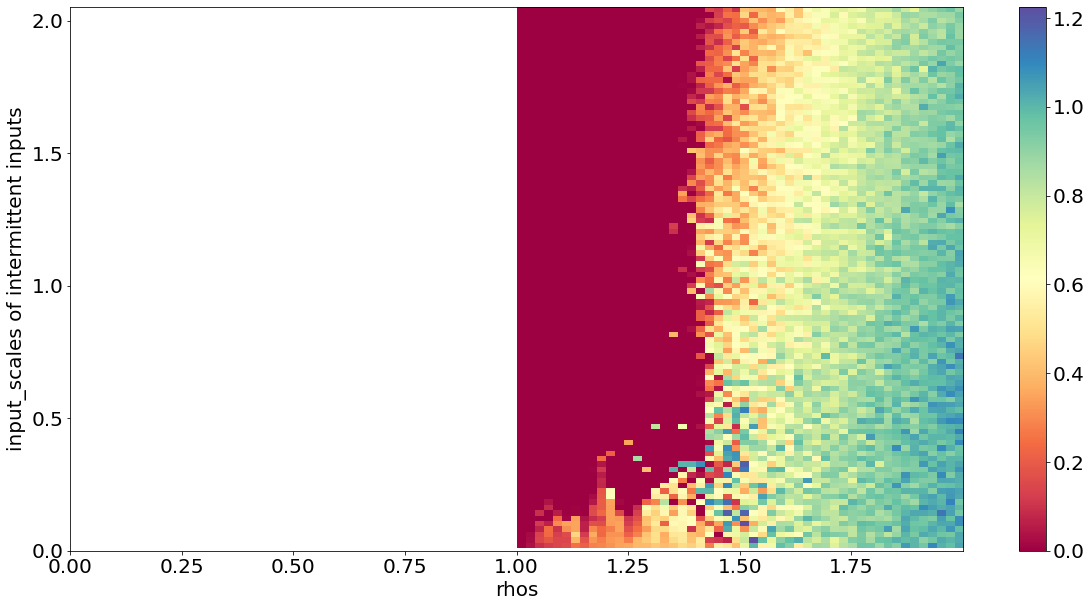

In [ ]:
plot_data=distance_rhos_ex[::-1, :]
print(plot_data)
#plot
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

extent=[rhos[0], rhos[-1], input_scales_ex[0], input_scales_ex[-1]]
print(extent)
bar1=ax1.imshow(plot_data, extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')

ax1.set_xlabel('rhos')
ax1.set_ylabel('input_scales of external inputs')

ax1.set_xticks(np.arange(0, rHigh, 0.25))
ax1.set_yticks(np.arange(0, exHigh, 0.25))

fig.colorbar(bar1, ax=ax1)


# 並列計算

In [14]:
import time
import threading
import multiprocessing

np.random.seed(1010)
Time_leng=2*10**4

exLow = 0.01
exHigh = 1.6/0.28*0.359
exN = 20
rLow = 0.1
rHigh = 2.0
rN = 10    # This sets how dense the bifurcation diagram will be

dim_u_spon=0
dim_rv=50
dim_u=1
density=1.0

input_scales_ex = np.linspace(exLow, exHigh, exN)
u=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
rhos = np.linspace(rLow, rHigh, rN)

input_scale_spon=0

np.random.seed(100)
x_init1=np.random.uniform(-1.0, 1.0, dim_rv)
np.random.seed(101)
x_init2=np.random.uniform(-1.0, 1.0, dim_rv)

rseed=1

#difference is defined by square norm of all states
distance_rhos_ex=np.empty((exN, rN))


def dist_rhos_ex(i, j):
    input_scale_ex=input_scales_ex[i]
    rho=rhos[j]

    u_ex = input_scale_ex*u
    """
    with lock:
        print(i, j, rho, input_scale_ex)
    """
    x_in_spon1, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, 
                                            input_scale_spon=input_scale_spon, rseed=rseed, 
                                            washout_len=0, seed_spon=0, x_init=x_init1, plot=False, verbose=False)

    x_in_spon2, states_series2=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=rho, 
                                            input_scale_spon=input_scale_spon, rseed=rseed, 
                                            washout_len=0, seed_spon=0, x_init=x_init2, plot=False, verbose=False)

    arr=np.sum((states_series1[-1000:, :] - states_series2[-1000:, :])**2, axis=1)
    val=np.average(arr)/float(dim_rv)
    #print( arr.shape,  val)
    #print(i, j, val)
    distance_rhos_ex[i, j] = val

def oneproc(kwargs):
    k, dim1_divs=kwargs
    print(k)
    time_st=time.time()
    st=int(k*dim1_divs)
    fn=int((k+1)*dim1_divs)
    for i in range(st, fn):
        dim2=rN
        for j in range(dim2):
            dist_rhos_ex(i, j)
    #print(k, " ", time.time()-time_st)
    return (time.time()-time_st)

process_nums=4
dim1_divs=(exN/process_nums)
kwargses=[]
for k in range(process_nums):
    # [dim1_divs*k: dim1_divs*(k+1), 0:100]
    kwargses.append((k, dim1_divs))
    #{'k': k, 'dim1_divs': dim1_divs}


with multiprocessing.Pool(processes=process_nums, maxtasksperchild=1) as pool: # ←変更
    r = pool.map(oneproc, kwargses)
    print(r)
"""
process_list = []
process_nums=10  # option=10, 20, 25, 50, 100
dim1_divs=(exN/process_nums)
print("dim1_divs = ", dim1_divs)
for k in range(process_nums):
    # [dim1_divs*k: dim1_divs*(k+1), 0:100]
    process=multiprocessing.Process(
        target=oneproc,
        kwargs={'k':k, 'dim1_divs': dim1_divs, 'lock':lock}
        )
    process.start()
    print(k,"th process start")
    process_list.append(process)

for process in process_list:
    process.join()
    print("1process_finished")
"""

102

3

[349.8281240463257, 350.5298218727112, 350.2798924446106, 350.03538727760315]


'\nprocess_list = []\nprocess_nums=10  # option=10, 20, 25, 50, 100\ndim1_divs=(exN/process_nums)\nprint("dim1_divs = ", dim1_divs)\nfor k in range(process_nums):\n    # [dim1_divs*k: dim1_divs*(k+1), 0:100]\n    process=multiprocessing.Process(\n        target=oneproc,\n        kwargs={\'k\':k, \'dim1_divs\': dim1_divs, \'lock\':lock}\n        )\n    process.start()\n    print(k,"th process start")\n    process_list.append(process)\n\nfor process in process_list:\n    process.join()\n    print("1process_finished")\n'

[[3.24428325e-316 0.00000000e+000 4.94065646e-324 4.94065646e-324
  6.90182467e-310 2.33419537e-313             nan 0.00000000e+000
  9.88131292e-324 6.90179131e-310]
 [6.90182760e-310 3.39519327e-313 1.32903659e-321 0.00000000e+000
  1.48219694e-323 6.90179131e-310 6.90182165e-310 4.66839074e-313
  1.32903659e-321 0.00000000e+000]
 [2.47032823e-323 4.94065646e-324 6.90182761e-310 4.24399158e-313
  1.35615618e+248 0.00000000e+000 2.96439388e-323 1.56700686e+248
  6.90182452e-310 3.60739284e-313]
 [1.48218776e-071 0.00000000e+000 3.95252517e-323 6.98902337e+228
  6.90182163e-310 2.54639495e-313 6.01347002e-154 0.00000000e+000
  4.44659081e-323 6.01346930e-154]
 [6.90182163e-310 4.88059032e-313 4.87301299e+199 0.00000000e+000
  4.94065646e-323 2.20117553e+213 6.90182475e-310 1.69759663e-313
  6.90184442e-310 0.00000000e+000]
 [5.43472210e-323 6.90179131e-310 6.90182163e-310 2.12199579e-313
  6.90182474e-310 0.00000000e+000 5.92878775e-323 6.90179131e-310
  6.90182164e-310 2.33419537e-313

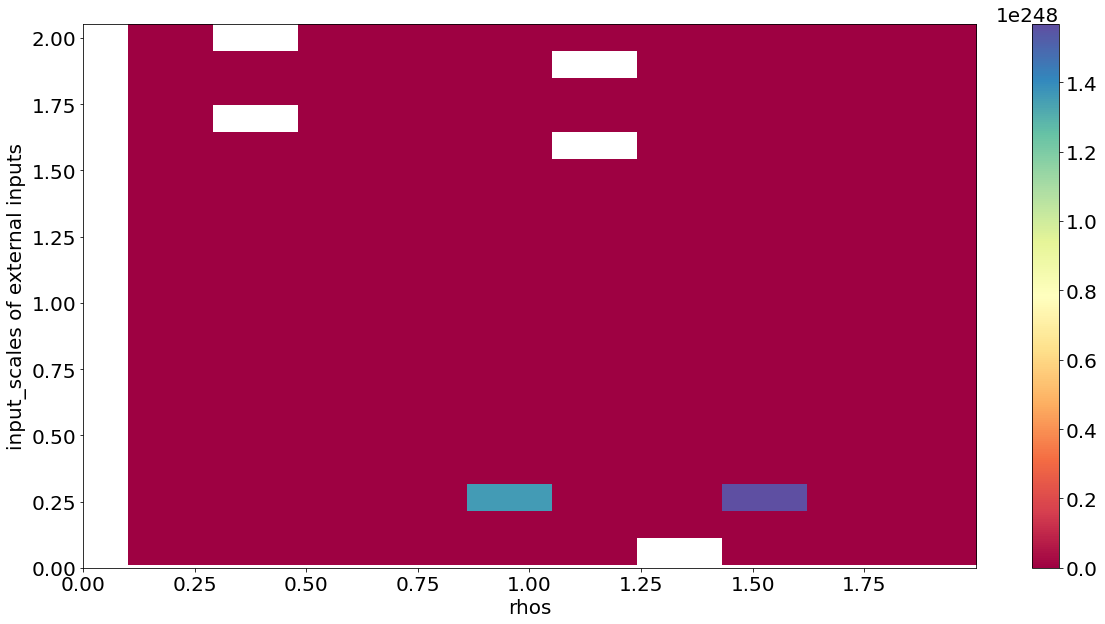

In [15]:
print(distance_rhos_ex)
plot_data=distance_rhos_ex[::-1, :]
print(plot_data)
#plot
plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()
ax1=fig.subplots(1,1)

extent=[rhos[0], rhos[-1], input_scales_ex[0], input_scales_ex[-1]]
print(extent)
bar1=ax1.imshow(plot_data, extent=extent, interpolation='nearest', cmap='Spectral', aspect='auto')

ax1.set_xlabel('rhos')
ax1.set_ylabel('input_scales of external inputs')

ax1.set_xticks(np.arange(0, rHigh, 0.25))
ax1.set_yticks(np.arange(0, exHigh, 0.25))

fig.colorbar(bar1, ax=ax1)
